# Classifier - myth vs history

This notebook builds and trains a classification model that determines if a Latin sentence is  historical or  mythological.  

In [2]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.version.VERSION)

2.8.0


In [93]:
checkpoint_dir = "./ckpt"
EPOCHS = 1
BATCH_SIZE = 128

In [43]:
# Define a simple model
def make_model():
    inputs = layers.Input(shape=(7680,))
    
    x = layers.Dense(4)(inputs)
    x = layers.Dense(4)(x)
    x = layers.Dense(4)(x)
    
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [44]:
# Create a basic model instance
model = make_model()

# Display the model's architecture
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7680)]            0         
                                                                 
 dense_8 (Dense)             (None, 4)                 30724     
                                                                 
 dense_9 (Dense)             (None, 4)                 20        
                                                                 
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 dense_11 (Dense)            (None, 2)                 10        
                                                                 
Total params: 30,774
Trainable params: 30,774
Non-trainable params: 0
_________________________________________________________________


In [76]:
def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print(latest_checkpoint)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    
    print("Creating a new model")
    model = make_model()

    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model

In [112]:
def train(train_features, train_labels, test_features, test_labels):
    model = make_or_restore_model() #Retrieve model from a checkpoint or make model

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False)
    
    history = model.fit(
        x=train_features,
        y=train_labels,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[model_checkpoint_callback],
        validation_data=(test_features, test_labels),
    )
    
    return history

In [113]:
def make_array(dataframe):
    noNones = dataframe.applymap(lambda x:-1 if x == 'None' else x)
    toFloats = noNones.to_numpy().astype(float)
    return toFloats

In [114]:
def get_dataset_partitions_pd(df, size, train_split=0.8, val_split=0.2):
    assert (train_split + val_split) == 1

    # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    
    train_ds = df_sample.iloc[:int(size*train_split)]
    val_ds = df_sample.iloc[int(size*train_split):]
    
    return train_ds, val_ds

In [115]:
# trains on 1/10 of total data
def trainSection(num):
    fileH = "history-dfs/" + str(num) + ".csv"
    fileM = "myth-dfs/" + str(num) + ".csv"

    df = pd.read_csv(fileH).drop(['Unnamed: 0'], axis=1).append(pd.read_csv(fileM).drop(['Unnamed: 0'], axis=1))
    df = df.fillna(0)
    train_data, val_data = get_dataset_partitions_pd(df, df.shape[0] ) # train and val are both dataframes partitioned
    
    # train model
    train_features = make_array(train_data[[str(i) for i in range(7680)]])
    train_labels = make_array(train_data[['isHistory']])

    val_features = make_array(val_data[[str(i) for i in range(7680)]])
    val_labels = make_array(val_data[['isHistory']])

    return train(train_features, train_labels, val_features, val_labels)

In [128]:
# gather data on loss and accuracy as the model trains
historyDF = pd.DataFrame(columns=['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# iterate through training data
for epoch in range(4):
    print(("Epoch", epoch))
    for i in range(10):
        print(("Training Num", i))
        historyDF = historyDF.append(pd.DataFrame(trainSection(i).history), ignore_index=True)

('Epoch', 0)
('Training Num', 0)
Creating a new model
13/13 [==============================] - 1s 83ms/step - loss: 0.6066 - accuracy: 0.6665 - val_loss: 0.4928 - val_accuracy: 0.7975
('Training Num', 1)
./ckpt/ckpt-loss=0.61
Restoring from ./ckpt/ckpt-loss=0.61
13/13 [==============================] - 1s 52ms/step - loss: 0.3708 - accuracy: 0.8698 - val_loss: 0.2868 - val_accuracy: 0.9250
('Training Num', 2)
./ckpt/ckpt-loss=0.37
Restoring from ./ckpt/ckpt-loss=0.37
13/13 [==============================] - 1s 53ms/step - loss: 0.2554 - accuracy: 0.9249 - val_loss: 0.2289 - val_accuracy: 0.9250
('Training Num', 3)
./ckpt/ckpt-loss=0.26
Restoring from ./ckpt/ckpt-loss=0.26
13/13 [==============================] - 1s 55ms/step - loss: 0.1736 - accuracy: 0.9599 - val_loss: 0.1757 - val_accuracy: 0.9425
('Training Num', 4)
./ckpt/ckpt-loss=0.17
Restoring from ./ckpt/ckpt-loss=0.17
13/13 [==============================] - 1s 51ms/step - loss: 0.1362 - accuracy: 0.9581 - val_loss: 0.1529 - v

13/13 [==============================] - 1s 55ms/step - loss: 0.0535 - accuracy: 0.9819 - val_loss: 0.0912 - val_accuracy: 0.9675
('Training Num', 4)
./ckpt/ckpt-loss=0.05
Restoring from ./ckpt/ckpt-loss=0.05
13/13 [==============================] - 1s 58ms/step - loss: 0.0483 - accuracy: 0.9825 - val_loss: 0.0816 - val_accuracy: 0.9650
('Training Num', 5)
./ckpt/ckpt-loss=0.05
Restoring from ./ckpt/ckpt-loss=0.05
13/13 [==============================] - 1s 73ms/step - loss: 0.0562 - accuracy: 0.9775 - val_loss: 0.0890 - val_accuracy: 0.9675
('Training Num', 6)
./ckpt/ckpt-loss=0.06
Restoring from ./ckpt/ckpt-loss=0.06
13/13 [==============================] - 1s 51ms/step - loss: 0.0572 - accuracy: 0.9793 - val_loss: 0.0956 - val_accuracy: 0.9650
('Training Num', 7)
./ckpt/ckpt-loss=0.06
Restoring from ./ckpt/ckpt-loss=0.06
13/13 [==============================] - 1s 51ms/step - loss: 0.0540 - accuracy: 0.9819 - val_loss: 0.0778 - val_accuracy: 0.9800
('Training Num', 8)
./ckpt/ckpt-lo

In [129]:
historyDF

,loss,accuracy,val_loss,val_accuracy
0,0.606607,0.666458,0.492772,0.7975
1,0.370821,0.869837,0.286771,0.9250
2,0.255416,0.924906,0.228887,0.9250
3,0.173635,0.959950,0.175699,0.9425
4,0.136198,0.958073,0.152872,0.9450
5,0.125784,0.964330,0.137450,0.9525
6,0.113120,0.963705,0.121657,0.9525
7,0.100156,0.965582,0.098569,0.9725
8,0.088897,0.969962,0.082117,0.9725
9,0.102111,0.965582,0.093073,0.9725


In [130]:
import matplotlib.pyplot as plt

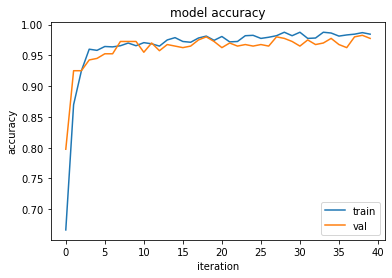

In [135]:
plt.plot(historyDF['accuracy'])
plt.plot(historyDF['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

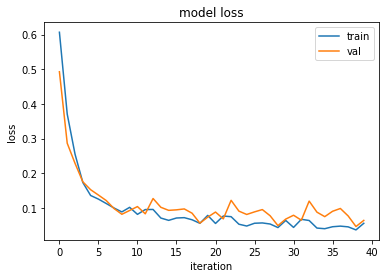

In [136]:
plt.plot(historyDF['loss'])
plt.plot(historyDF['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train', 'val'], loc='upper right')
plt.show()